## Trực quan hóa và phân tích dữ liệu

In [ ]:
# import pandas as pd
# df_train = pd.read_csv('publics_train_metadata.csv')
# df_train.head()

In [49]:
import pandas as pd 


df_dev = pd.read_csv("/work/quang.domanh/datasets/fas_dataset/OULU-NPU/Baseline/Protocol_2/Dev.txt", header=None)
df_test = pd.read_csv("/work/quang.domanh/datasets/fas_dataset/OULU-NPU/Baseline/Protocol_2/Test.txt", header=None)
df_train = pd.read_csv("/work/quang.domanh/datasets/fas_dataset/OULU-NPU/Baseline/Protocol_2/Train.txt", header=None)

df = pd.concat([df_dev, df_test, df_train])
df[0].value_counts()

0
-1    1620
 1     990
-2     360
Name: count, dtype: int64

In [46]:
df_dev[0].value_counts(), df_test[0].value_counts(), df_train[0].value_counts()

(0
 -1    720
  1    180
 Name: count, dtype: int64,
 0
 -1    240
 -2    240
  1    120
 Name: count, dtype: int64,
 0
 -1    960
  1    240
 Name: count, dtype: int64)

In [40]:
import os
from pathlib import Path


dirs = {
    'CASIA': '/work/quang.domanh/datasets/fas_dataset/CASIA/CASIA_faceAntisp', # CASIA
    'celeba': '/work/quang.domanh/datasets/fas_dataset/celeba-spoof/CelebA_Spoof_/CelebA_Spoof/Data', # celeba
    'MSU': '/work/quang.domanh/datasets/fas_dataset/MSU-MFSD/scene01', # MSU-MFSD
    'SiW': '/work/quang.domanh/datasets/fas_dataset/SiW-Mv2/SiW-Mv2', # SiW
    'VFT': '/work/quang.domanh/datasets/fas_dataset/live_vft/live',
}

dist_path = {
    'CASIA': [],
    'celeba': [],
    'MSU': [],
    'SiW': [],
    'VFT': [],
}

csv_data = []

for key in dirs.keys():
    for (root, _, files) in os.walk(dirs[key]):
        if len(files) > 0:
            path_files = []
            flag = 1
            for file in files:
                if Path(file).suffix in ['.txt', '.face', '.pdf']:
                    continue
                path = os.path.join(root, file)
                if 'live' in path.lower() or 'real' in path.lower():
                    flag = 0
                csv_data.append([key, path, flag])
                path_files.append(path)
            dist_path[key] += path_files

In [41]:
csv_data[0]

['CASIA',
 '/work/quang.domanh/datasets/fas_dataset/CASIA/CASIA_faceAntisp/test_release/15/spoof/8.avi',
 1]

In [42]:
import pandas as pd

df_fas = pd.DataFrame(csv_data, columns=['dataset', 'path', 'label'])
df_fas.to_csv("/work/quang.domanh/face-anti-spoofing/csv_data/fas_dataset.csv", index=False)
df_fas.head()

,dataset,path,label
0,CASIA,/work/quang.domanh/datasets/fas_dataset/CASIA/...,1
1,CASIA,/work/quang.domanh/datasets/fas_dataset/CASIA/...,1
2,CASIA,/work/quang.domanh/datasets/fas_dataset/CASIA/...,1
3,CASIA,/work/quang.domanh/datasets/fas_dataset/CASIA/...,1
4,CASIA,/work/quang.domanh/datasets/fas_dataset/CASIA/...,1


In [44]:
import pandas as pd

df = pd.read_csv("/work/quang.domanh/face-anti-spoofing/csv_data/fas_dataset.csv")
df.head()

,dataset,path,label
0,CASIA,/work/quang.domanh/datasets/fas_dataset/CASIA/...,1
1,CASIA,/work/quang.domanh/datasets/fas_dataset/CASIA/...,1
2,CASIA,/work/quang.domanh/datasets/fas_dataset/CASIA/...,1
3,CASIA,/work/quang.domanh/datasets/fas_dataset/CASIA/...,1
4,CASIA,/work/quang.domanh/datasets/fas_dataset/CASIA/...,1


In [47]:
import os

tail = ['.jpg', '.png', '.mov', '.avi', '.mp4']
df_filtered = df[df['path'].apply(lambda x: os.path.splitext(x)[1] in tail)]
grouped_by_extension = df_filtered.groupby(df_filtered['path'].apply(lambda x: os.path.splitext(x)[1])).size()

In [59]:
total_sample_size = 3 * 1000

def proportional_sampler(group, total_sample_size):
    proportion = len(group) / len(df_filtered)
    n_samples = int(proportion * total_sample_size)
    return group.sample(n=min(n_samples, len(group)), random_state=100)

sampled_df = df_filtered.groupby(df_filtered['path'].apply(lambda x: os.path.splitext(x)[1])).apply(proportional_sampler, total_sample_size).reset_index(drop=True)

display(sampled_df.head())
display(sampled_df.shape)

,dataset,path,label
0,CASIA,/work/quang.domanh/datasets/fas_dataset/CASIA/...,0
1,CASIA,/work/quang.domanh/datasets/fas_dataset/CASIA/...,1
2,CASIA,/work/quang.domanh/datasets/fas_dataset/CASIA/...,0
3,CASIA,/work/quang.domanh/datasets/fas_dataset/CASIA/...,1
4,CASIA,/work/quang.domanh/datasets/fas_dataset/CASIA/...,1


(2998, 3)

In [60]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(sampled_df, test_size=0.3, random_state=42)

print("Shape of df_train:", df_train.shape)
print("Shape of df_val:", df_val.shape)

Shape of df_train: (2098, 3)
Shape of df_val: (900, 3)


In [62]:
import os
from collections import Counter

def count_extensions_in_df(dataframe):
    """
    Counts the number of files by their extensions in a DataFrame.

    Args:
        dataframe (pd.DataFrame): The DataFrame with a 'path' column.

    Returns:
        Counter: A Counter object with file extensions as keys and counts as values.
    """
    extensions = [os.path.splitext(path)[1] for path in dataframe['path']]
    extension_counts = Counter(extensions)
    return extension_counts

print("File extension counts in df_train:")
print(count_extensions_in_df(df_train))

print("\nFile extension counts in df_val:")
print(count_extensions_in_df(df_val))

File extension counts in df_train:
Counter({'.jpg': 1861, '.png': 228, '.mov': 4, '.avi': 4, '.mp4': 1})

File extension counts in df_val:
Counter({'.jpg': 789, '.png': 108, '.mp4': 1, '.avi': 1, '.mov': 1})


In [63]:
df_train.to_csv("/work/quang.domanh/face-anti-spoofing/csv_data/fas_train_sample.csv", index=False)
df_val.to_csv("/work/quang.domanh/face-anti-spoofing/csv_data/fas_val_sample.csv", index=False)

In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Giả sử df_fas là DataFrame bạn đã tạo
# Bước 1: Chia train và (val+test)
train_df, val_test_df = train_test_split(
    df_fas,
    test_size=0.3,          # 30% để lại cho val+test
    stratify=df_fas['label'],
    random_state=42,
    shuffle=True,
)

# Bước 2: Chia tiếp val và test từ val_test_df
val_df, test_df = train_test_split(
    val_test_df,
    test_size=0.5,          # chia đôi val và test (15% + 15%)
    stratify=val_test_df['label'],
    random_state=42,
    shuffle=True,
)

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

# Xuất ra CSV nếu muốn
train_df.to_csv("/work/quang.domanh/face-anti-spoofing/csv_data/fas_train.csv", index=False)
val_df.to_csv("/work/quang.domanh/face-anti-spoofing/csv_data/fas_val.csv", index=False)
test_df.to_csv("/work/quang.domanh/face-anti-spoofing/csv_data/fas_test.csv", index=False)


Train size: 419408
Val size: 89873
Test size: 89874


In [2]:
import pandas as pd 


# train_df = pd.read_csv("/work/quang.domanh/face-anti-spoofing/csv_data/fas_train.csv", usecols=['path', 'label'])
# val_df = pd.read_csv("/work/quang.domanh/face-anti-spoofing/csv_data/fas_val.csv", usecols=['path', 'label'])
# test_df = pd.read_csv("/work/quang.domanh/face-anti-spoofing/csv_data/fas_test.csv", usecols=['path', 'label'])

In [6]:
train_df.head(320).to_csv("/work/quang.domanh/face-anti-spoofing/csv_data/fas_train_320.csv")
val_df.head(320).to_csv("/work/quang.domanh/face-anti-spoofing/csv_data/fas_val_320.csv")
test_df.head(320).to_csv("/work/quang.domanh/face-anti-spoofing/csv_data/fas_test_320.csv")

In [5]:
train_df = pd.read_csv("/data02/manhquang/dataset/celeba-spoof/CelebA_Spoof_/CelebA_Spoof/metas/intra_test/test_label.txt", header=None, sep=" ")
train_df.head(320).to_csv("test_320.csv", index=False, sep=",")

In [66]:
train_df['label'].value_counts(), train_df['dataset'].value_counts()

(label
 1    265120
 0    154288
 Name: count, dtype: int64,
 dataset
 celeba    392975
 VFT        24590
 SiW         1222
 CASIA        423
 MSU          198
 Name: count, dtype: int64)

In [67]:
val_df['label'].value_counts(), val_df['dataset'].value_counts()

(label
 1    56811
 0    33062
 Name: count, dtype: int64,
 dataset
 celeba    84263
 VFT        5237
 SiW         245
 CASIA        88
 MSU          40
 Name: count, dtype: int64)

In [68]:
test_df['label'].value_counts(), test_df['dataset'].value_counts()

(label
 1    56812
 0    33062
 Name: count, dtype: int64,
 dataset
 celeba    84337
 VFT        5173
 SiW         233
 CASIA        89
 MSU          42
 Name: count, dtype: int64)

In [2]:
import os
from collections import Counter

def df_count_files_by_extension(dataframe):
    """
    Counts the number of files by their extensions in a DataFrame.

    Args:
        dataframe (pd.DataFrame): The DataFrame with a 'path' column.

    Returns:
        Counter: A Counter object with file extensions as keys and counts as values.
    """
    extensions = [os.path.splitext(path)[1] for path in dataframe['path']]
    extension_counts = Counter(extensions)
    return extension_counts


def count_files_by_extension(path_files):
    """
    Counts the number of files by their extensions in a DataFrame.

    Args:
        dataframe (pd.DataFrame): The DataFrame with a 'path' column.

    Returns:
        Counter: A Counter object with file extensions as keys and counts as values.
    """
    extensions = [os.path.splitext(path)[1] for path in path_files]
    extension_counts = Counter(extensions)
    return extension_counts

# Example usage:
# extension_counts = count_files_by_extension(df_train)
# print(extension_counts)

In [38]:
df_count_files_by_extension(dataframe=df_fas)

Counter({'.jpg': 494405,
         '.png': 67170,
         '.mov': 1134,
         '.avi': 1000,
         '.mp4': 446})

In [37]:
# Load video and extract a random frame
import cv2, random

img_path = '/work/quang.domanh/datasets/fas_dataset/CASIA/CASIA_faceAntisp/test_release/11/live/HR_1.avi'

cap = cv2.VideoCapture(img_path)
if not cap.isOpened():
    print(f"Error: Could not open video file {img_path}")
else:
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_count > 0:
        print("frame_count : ", frame_count)
        # random_frame_index = random.randint(0, frame_count - 1) # chọn ngẫu nhiên 1 frame
        random_frame_index = 144
        print("random_frame_index : ", random_frame_index)
        cap.set(cv2.CAP_PROP_POS_FRAMES, random_frame_index) # chọn ngẫu nhiên 1 frame
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # Convert to RGB
            # image_x, binary_mask = self.get_single_image_x(frame)
            print("frame : ", frame.shape)
        else:
            print(f"Warning: Could not read frame {random_frame_index} from {img_path}")
    else:
        print(f"Warning: Video file {img_path} has no frames.")
    cap.release()

frame_count :  145
random_frame_index :  144


In [6]:
print('CASIA', count_files_by_extension(path_files=dist_path['CASIA']))
print('celeba', count_files_by_extension(path_files=dist_path['celeba']))
print('MSU', count_files_by_extension(path_files=dist_path['MSU']))
print('SiW', count_files_by_extension(path_files=dist_path['SiW']))

CASIA Counter({'.avi': 600})
celeba Counter({'.txt': 561575, '.jpg': 494405, '.png': 67170})
MSU Counter({'.face': 280, '.mov': 140, '.mp4': 140})
SiW Counter({'.mov': 994, '.avi': 400, '.mp4': 306, '.pdf': 1})


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming extension_counts is already calculated from df_train using the count_files_by_extension function
# If not, you would need to call the function first:
extension_counts = count_files_by_extension(df_train)

# Prepare data for plotting
extensions = list(extension_counts.keys())
counts = list(extension_counts.values())

# Create a bar plot
plt.figure(figsize=(6, 4))
bars = sns.barplot(x=extensions, y=counts, palette='viridis') # Using a color palette

plt.title('Distribution of File Extensions in df_train')
plt.xlabel('File Extension')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability

# Add legend (optional, as extensions are on x-axis, but can be useful for clarity)
handles = [plt.Rectangle((0, 0), 1, 1, color=bars.patches[i].get_facecolor()) for i in range(len(extensions))]
plt.legend(handles, extensions, title="Extensions")

plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each label in df_train
label_counts = df_train['label'].value_counts().sort_index()

# Create a bar plot with different colors and a legend
plt.figure(figsize=(6, 4))
colors = ['skyblue', 'lightcoral'] # Define colors for each bar
bars = sns.barplot(x=label_counts.index, y=label_counts.values, palette=colors)
plt.title('Distribution of Live and Spoof Labels')
plt.xlabel('Label (0: Live, 1: Spoof)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Live', 'Spoof'])

# Add legend
legend_labels = ['Live', 'Spoof']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(colors))]
plt.legend(handles, legend_labels, title="Label")

plt.show()

In [71]:
import cv2
import random
import os


def get_frames(base_dir, video_paths):
    frames = []
    for video_path in video_paths:
        full_video_path = os.path.join(base_dir, video_path)
        cap = cv2.VideoCapture(full_video_path)

        if not cap.isOpened():
            print(f"Error: Could not open video file {full_video_path}")
            continue

        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        if frame_count > 0:
            random_frame_index = random.randint(0, frame_count - 1)
            cap.set(cv2.CAP_PROP_POS_FRAMES, random_frame_index)
            ret, frame = cap.read()

            if ret:
                frames.append(frame)
            else:
                print(f"Warning: Could not read frame {random_frame_index} from {full_video_path}")
        else:
            print(f"Warning: Video file {full_video_path} has no frames.")

        cap.release()

    print(f"Successfully extracted {len(frames)} frames from {len(video_paths)} videos.")
    return frames

# get_frames(base_dir = '/content/drive/MyDrive/HAUI/AIO/2025/publics_data_train')

In [74]:
from PIL import Image
import math
import matplotlib.pyplot as plt # Import matplotlib for displaying with title
import cv2 # Import cv2 for color conversion


def display_frames(frames):
    if not frames:
        print("No frames were extracted. Cannot create collage.")
    else:
        # Determine the number of rows and columns for the collage
        num_frames = len(frames)
        cols = math.ceil(math.sqrt(num_frames))
        rows = math.ceil(num_frames / cols)

        # Define the size for each frame in the collage
        frame_size = (200, 200) # Resize each frame to 200x200 pixels

        # Calculate the dimensions of the collage image
        collage_width = cols * frame_size[0]
        collage_height = rows * frame_size[1]

        # Create a new blank image for the collage
        collage_image = Image.new('RGB', (collage_width, collage_height))

        # Paste each resized frame onto the collage image
        for index, frame in enumerate(frames):
            # Convert frame from BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Convert numpy array to PIL Image
            img = Image.fromarray(frame_rgb)
            # Resize the frame
            img_resized = img.resize(frame_size)

            # Calculate the position to paste the frame
            row_index = index // cols
            col_index = index % cols
            paste_x = col_index * frame_size[0]
            paste_y = row_index * frame_size[1]

            # Paste the resized frame onto the collage
            collage_image.paste(img_resized, (paste_x, paste_y))

        # Display the collage with a title
        plt.figure(figsize=(8, 8)) # Adjust figure size as needed
        plt.imshow(collage_image)
        plt.title('Collage of Random Frames from Videos')
        plt.axis('off') # Hide axes
        plt.show()

# display_frames(frames)

In [76]:
df_live = train_df[train_df['label'] == 0].copy()
display(df_live.head())

,dataset,path,label
215670,celeba,/work/quang.domanh/datasets/fas_dataset/celeba...,0
453409,celeba,/work/quang.domanh/datasets/fas_dataset/celeba...,0
42094,celeba,/work/quang.domanh/datasets/fas_dataset/celeba...,0
580684,VFT,/work/quang.domanh/datasets/fas_dataset/live_v...,0
122839,celeba,/work/quang.domanh/datasets/fas_dataset/celeba...,0


Sampled 9 video paths:
/work/quang.domanh/datasets/fas_dataset/celeba-spoof/CelebA_Spoof_/CelebA_Spoof/Data/train/1744/live/428490.jpg
/work/quang.domanh/datasets/fas_dataset/live_vft/live/query-impala-89455.csv_d3e2d8fd-1670-4e2d-a8cd-da8727d45bc4.jpg
/work/quang.domanh/datasets/fas_dataset/celeba-spoof/CelebA_Spoof_/CelebA_Spoof/Data/train/5125/live/481138.jpg
/work/quang.domanh/datasets/fas_dataset/celeba-spoof/CelebA_Spoof_/CelebA_Spoof/Data/train/5540/live/042559.jpg
/work/quang.domanh/datasets/fas_dataset/live_vft/live/query-impala-89455.csv_84a6cdb3-f78b-44e3-980e-d18dc43a652b.jpg
/work/quang.domanh/datasets/fas_dataset/celeba-spoof/CelebA_Spoof_/CelebA_Spoof/Data/train/4598/live/071687.jpg
/work/quang.domanh/datasets/fas_dataset/live_vft/live/query-impala-89455.csv_5462ecbc-1f6b-4901-9112-73bfad1aa99f.jpg
/work/quang.domanh/datasets/fas_dataset/celeba-spoof/CelebA_Spoof_/CelebA_Spoof/Data/train/700/live/100235.jpg
/work/quang.domanh/datasets/fas_dataset/celeba-spoof/CelebA_Spoo

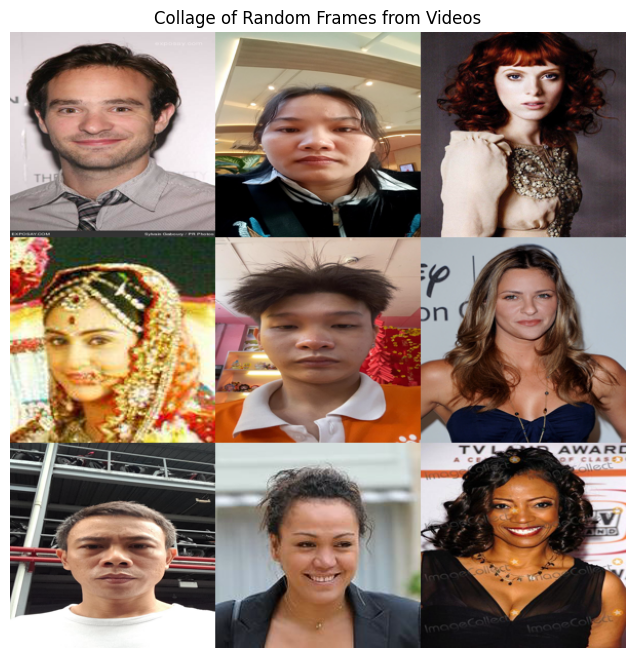

In [79]:
num_videos_to_sample = 9
sampled_videos = df_live.sample(n=num_videos_to_sample, random_state=30) # Added random_state for reproducibility
video_paths = sampled_videos['path'].tolist()
print(f"Sampled {num_videos_to_sample} video paths:")
for path in video_paths:
    print(path)

live_frames = get_frames(base_dir='', video_paths=video_paths)
print("\n SUMMARY FRAME VIDEO LIVE \n")
display_frames(frames=live_frames)

In [80]:
df_spoof = train_df[train_df['label'] == 1].copy()
display(df_spoof.head())

,dataset,path,label
332941,celeba,/work/quang.domanh/datasets/fas_dataset/celeba...,1
542664,celeba,/work/quang.domanh/datasets/fas_dataset/celeba...,1
140286,celeba,/work/quang.domanh/datasets/fas_dataset/celeba...,1
278040,celeba,/work/quang.domanh/datasets/fas_dataset/celeba...,1
377528,celeba,/work/quang.domanh/datasets/fas_dataset/celeba...,1


Sampled 9 video paths:
/work/quang.domanh/datasets/fas_dataset/celeba-spoof/CelebA_Spoof_/CelebA_Spoof/Data/train/4306/spoof/051182.jpg
/work/quang.domanh/datasets/fas_dataset/celeba-spoof/CelebA_Spoof_/CelebA_Spoof/Data/test/6158/spoof/515464.png
/work/quang.domanh/datasets/fas_dataset/celeba-spoof/CelebA_Spoof_/CelebA_Spoof/Data/train/6391/spoof/402319.jpg
/work/quang.domanh/datasets/fas_dataset/celeba-spoof/CelebA_Spoof_/CelebA_Spoof/Data/train/8022/spoof/066744.jpg
/work/quang.domanh/datasets/fas_dataset/celeba-spoof/CelebA_Spoof_/CelebA_Spoof/Data/train/9575/spoof/184166.jpg
/work/quang.domanh/datasets/fas_dataset/celeba-spoof/CelebA_Spoof_/CelebA_Spoof/Data/train/3874/spoof/456281.jpg
/work/quang.domanh/datasets/fas_dataset/celeba-spoof/CelebA_Spoof_/CelebA_Spoof/Data/test/6223/spoof/524777.png
/work/quang.domanh/datasets/fas_dataset/celeba-spoof/CelebA_Spoof_/CelebA_Spoof/Data/test/6056/spoof/547753.png
/work/quang.domanh/datasets/fas_dataset/celeba-spoof/CelebA_Spoof_/CelebA_Sp

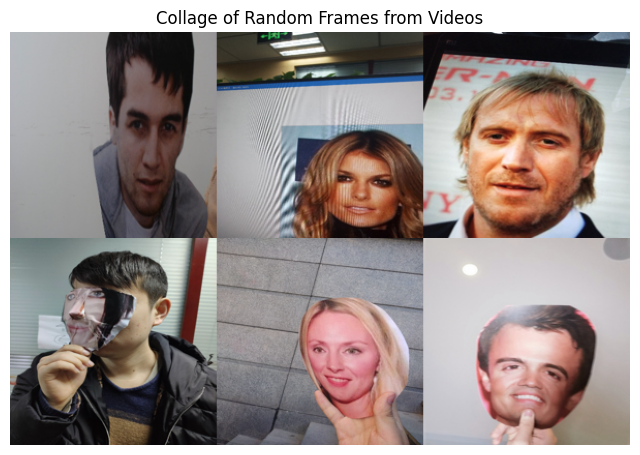

In [81]:
num_videos_to_sample = 9
sampled_videos = df_spoof.sample(n=num_videos_to_sample, random_state=100) # Added random_state for reproducibility
video_paths = sampled_videos['path'].tolist()
print(f"Sampled {num_videos_to_sample} video paths:")
for path in video_paths:
    print(path)

live_frames = get_frames(base_dir='/content/drive/MyDrive/HAUI/AIO/2025/publics_data_train', video_paths=video_paths)
print("\n SUMMARY FRAME VIDEO SPOOF \n")
display_frames(frames=live_frames)

## Triển khai bài toán minh họa

In [ ]:
import pandas as pd

df_train = pd.read_csv('/content/drive/MyDrive/HAUI/AIO/2025/publics_train_metadata.csv')
df_train.head()

In [ ]:
from sklearn.model_selection import train_test_split

# Split the DataFrame into training and validation sets with stratification
train_df, val_df = train_test_split(
    df_train,
    test_size=0.2,  # 20% for validation
    random_state=42, # for reproducibility
    stratify=df_train['label'] # Stratify based on the 'label' column
)

print("Data split into training and validation sets:")
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

print("\nLabel distribution in training set:")
display(train_df['label'].value_counts())

print("\nLabel distribution in validation set:")
display(val_df['label'].value_counts())

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import random
from PIL import Image
from torchvision import transforms

class FaceAntiSpoofingDataset(Dataset):
    def __init__(self, dataframe, base_dir, task='train', transform=None):
        self.dataframe = dataframe
        self.base_dir = base_dir
        self.transform = transform
        self.task = task

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        label = ''
        img_path = os.path.join(self.base_dir, self.dataframe.iloc[idx, 0])
        if self.task == 'train':
            label = self.dataframe.iloc[idx, 1]

        frame = None
        _, file_extension = os.path.splitext(img_path)
        file_extension = file_extension.lower()

        if file_extension.lower() in ['.jpg', '.jpeg', '.png']:
            # Load image
            frame = cv2.imread(img_path)
            if frame is not None:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # Convert to RGB
            else:
                print(f"Error: Could not read image file {img_path}")

        elif file_extension.lower() in ['.mp4', '.mov', '.avi', '.mkv']:
            # Load video and extract a random frame
            cap = cv2.VideoCapture(img_path)
            if not cap.isOpened():
                print(f"Error: Could not open video file {img_path}")
            else:
                frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                if frame_count > 0:
                    random_frame_index = random.randint(0, frame_count - 1)
                    cap.set(cv2.CAP_PROP_POS_FRAMES, random_frame_index)
                    ret, frame = cap.read()
                    if ret:
                        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # Convert to RGB
                    else:
                        print(f"Warning: Could not read frame {random_frame_index} from {img_path}")
                else:
                    print(f"Warning: Video file {img_path} has no frames.")
                cap.release()

        else:
            print(f"Warning: Unsupported file format: {file_extension} for file {img_path}")

        if frame is not None:
            frame = cv2.resize(frame, (224, 224)) # Resize to a fixed size
            frame = Image.fromarray(frame) # Convert to PIL Image for transformations

        if self.transform:
            frame = self.transform(frame)

        return frame, label

# Define transformations
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet normalization
])

# Assuming df_train and df_val DataFrames are already created in a previous step
# Replace with your actual base directory for the data
base_data_dir = 'publics_data_train'

# Create Datasets
train_dataset = FaceAntiSpoofingDataset(dataframe=train_df, base_dir=base_data_dir, transform=data_transforms)
val_dataset = FaceAntiSpoofingDataset(dataframe=val_df, base_dir=base_data_dir, transform=data_transforms) # Assuming df_val exists

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2) # Assuming df_val exists

print("PyTorch Datasets and DataLoaders created.")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load a pre-trained ResNet18 model
model = models.resnet18(weights=True)

for param in model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2) # 2 output classes: 0 (Live) and 1 (Spoof)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("ResNet18 model loaded and modified.")
print(f"Using device: {device}")

In [ ]:
from tqdm import tqdm

# Training loop

num_epochs = 2  # You can adjust the number of epochs

for epoch in range(1, num_epochs + 1):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in tqdm(train_dataloader, desc=f"[Epoch {epoch}] Train"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    running_corrects = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_dataloader, desc=f"[Epoch {epoch}] Val"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            running_corrects += torch.sum(preds == labels.data)

    epoch_acc = running_corrects.double() / len(val_dataset)
    print(f"Validation Accuracy: {epoch_acc:.4f}")

print("Training finished.")

In [ ]:
import torch

# Define the path to save the model weights
model_save_path = 'resnet18_face_anti_spoofing.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model weights saved to {model_save_path}")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Evaluate the model on the validation set
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in val_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Generate classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Live', 'Spoof']))

# Generate confusion matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(all_labels, all_preds)
print(conf_matrix)

# Optional: Display confusion matrix as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Live', 'Spoof'], yticklabels=['Live', 'Spoof'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/HAUI/AIO/2025/publics_test_metadata.csv')
df_test.head()

In [ ]:
# Define transformations
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet normalization
])

base_data_dir = 'data_test'

# Create Datasets
test_dataset = FaceAntiSpoofingDataset(dataframe=df_test, base_dir=base_data_dir, task='test', transform=data_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2) # Assuming df_val exists
print("load test_dataloader")

In [ ]:
import torch
import pandas as pd
from tqdm import tqdm

# Set the model to evaluation mode
model.eval()

test_predictions = []
test_uuids = []

# Ensure the model is on the correct device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    # Iterate through the test dataloader
    for inputs, _ in tqdm(test_dataloader, desc="Predicting on test data"):
        inputs = inputs.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Extend the lists with predictions and corresponding UUIDs
        test_predictions.extend(preds.cpu().numpy())
        # You need to get the UUIDs corresponding to the current batch from your test_dataloader
        current_batch_uuids = df_test['uuid'][len(test_predictions) - len(preds):len(test_predictions)].tolist()
        test_uuids.extend(current_batch_uuids)


# Create a submission DataFrame
submission_df = pd.DataFrame({'uuid': test_uuids, 'label_pred': test_predictions})

# Save the submission DataFrame to a CSV file
submission_output_path = 'submit_sample.csv'
submission_df.to_csv(submission_output_path, index=False)

print(f"Submission file saved to {submission_output_path}")
display(submission_df.head())